#### Set Test Environment

In [1]:
import torch
import torchaudio
import pandas as pd
import os
from torch.utils.data import DataLoader, Dataset
from transformers import AutoFeatureExtractor
from sklearn.metrics import accuracy_score
import numpy as np



#### Parameters

⚠️ Notice: change the corresponding parameters in the constructor of 'DistilHuBERTClassifier' of train.py to match the testing model.

In [2]:
model_path = "./SemanticVAD(2_2000).pt" 
csv_path = "./dataset/binary_classification/test/test.csv"
sample_rate = 16000
batch_size = 1
test_mode = 1
test_size = 1000
num_classes = 2

#### Dataset Class

In [3]:
class AudioDataset(Dataset):
    def __init__(self, csv_file, feature_extractor):
        self.data = pd.read_csv(csv_file)
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data.iloc[idx]['filepath']
        label = self.data.iloc[idx]['labels']
        waveform, sr = torchaudio.load(file_path)
        if sr != sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
        inputs = self.feature_extractor(
            waveform.squeeze().numpy(),
            sampling_rate=sample_rate,
            return_tensors="pt"
        )
        input_values = inputs['input_values'].squeeze(0)  # [seq_len]
        return input_values, label

#### Load Models

In [4]:
from train import DistilHuBERTClassifier

feature_extractor = AutoFeatureExtractor.from_pretrained("ntu-spml/distilhubert")
from transformers import AutoModel
base_encoder = AutoModel.from_pretrained("ntu-spml/distilhubert")
model = DistilHuBERTClassifier(base_encoder, num_labels=2)
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

test_dataset = AudioDataset(csv_path, feature_extractor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Test

In [5]:
all_preds = []
all_labels = []


with torch.no_grad():
    for i, batch in enumerate(test_loader):
        input_values, labels = batch
        input_values = input_values.to(torch.float32)
        
        logits = model(input_values=input_values).logits
        probs = torch.softmax(logits, dim=-1)
        top2_probs, top2_indices = torch.topk(probs, 2, dim=-1)
        
        CONFIDENCE_MARGIN = 0.5
        
        preds = []
        for j in range(probs.size(0)):
            if (top2_probs[j, 0] - top2_probs[j, 1]) > CONFIDENCE_MARGIN:
                preds.append(top2_indices[j, 0].item())
            else:
                preds.append(4)
        
        preds = torch.tensor(preds)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        
        for idx in range(len(labels)):
            print(f"Sample {i * batch_size + idx} | True Label: {labels[idx].item()} | Predicted Label: {preds[idx].item()}")
        if i >= test_size:
            break


Sample 0 | True Label: 1 | Predicted Label: 1
Sample 1 | True Label: 1 | Predicted Label: 1
Sample 2 | True Label: 0 | Predicted Label: 0
Sample 3 | True Label: 1 | Predicted Label: 0
Sample 4 | True Label: 0 | Predicted Label: 0
Sample 5 | True Label: 1 | Predicted Label: 1
Sample 6 | True Label: 0 | Predicted Label: 0
Sample 7 | True Label: 0 | Predicted Label: 0
Sample 8 | True Label: 1 | Predicted Label: 1
Sample 9 | True Label: 1 | Predicted Label: 1
Sample 10 | True Label: 0 | Predicted Label: 0
Sample 11 | True Label: 1 | Predicted Label: 1
Sample 12 | True Label: 1 | Predicted Label: 1
Sample 13 | True Label: 1 | Predicted Label: 1
Sample 14 | True Label: 1 | Predicted Label: 1
Sample 15 | True Label: 0 | Predicted Label: 0
Sample 16 | True Label: 1 | Predicted Label: 1
Sample 17 | True Label: 1 | Predicted Label: 1
Sample 18 | True Label: 0 | Predicted Label: 0
Sample 19 | True Label: 1 | Predicted Label: 1
Sample 20 | True Label: 1 | Predicted Label: 1
Sample 21 | True Label:

In [6]:

# ====== Total Accuracy ======
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Overall Test Accuracy: {overall_accuracy*100:.2f}%")

# ====== Seperate Accuracy ======
for cls in range(num_classes):
    cls_idx = (all_labels == cls)
    if cls_idx.sum() == 0:
        print(f"⚠️ Class {cls} has no samples.")
        continue
    cls_acc = (all_preds[cls_idx] == all_labels[cls_idx]).sum() / cls_idx.sum()
    print(f"🎯 Class {cls} Accuracy: {cls_acc*100:.2f}%")


# ====== Calculate misclassification rate: Classes 1/2/3 wrongly predicted as Class 0 ======
# Select all samples whose true label is not 0 (i.e., true labels are 1, 2, or 3)
non_0_idx = (all_labels != 0)
if non_0_idx.sum() == 0:
    print(f"⚠️ No samples for classes 1, 2, or 3.")
else:
    # Among samples truly labeled 1/2/3, count how many were predicted as 0
    predicted_as_0 = (all_preds[non_0_idx] == 0).sum()
    # Total number of samples with true labels 1/2/3
    total_non_0 = non_0_idx.sum()
    # Calculate misclassification rate
    misdiagnosis_rate = predicted_as_0 / total_non_0
    if num_classes>2:
        print(f"🚨 Among samples truly 1/2/3..., {misdiagnosis_rate*100:.2f}% were misclassified as Backchannel (0).")


✅ Overall Test Accuracy: 96.30%
🎯 Class 0 Accuracy: 98.43%
🎯 Class 1 Accuracy: 94.12%


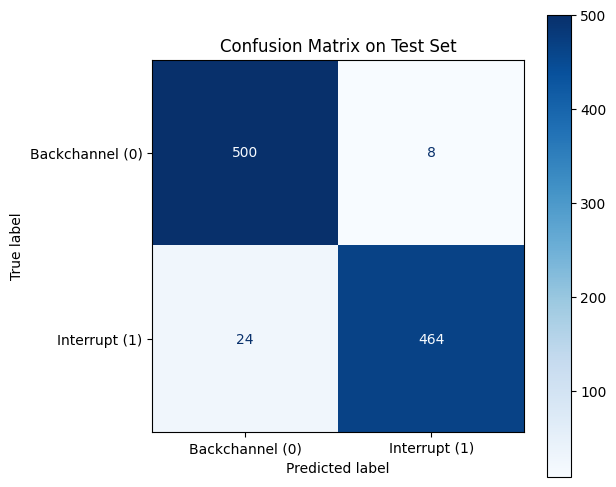

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

# Display the confusion matrix
if num_classes == 2:
    display_label = ["Backchannel (0)", "Interrupt (1)"]
else:
    display_label = ["Backchannel (0)", "Interrupt (1)", "Statement (2)", "TurnToEnd (3)"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_label)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.title("Confusion Matrix on Test Set")
plt.show()